In [1]:
from keras.utils import to_categorical
from keras.optimizers import Adam, Adadelta, SGD
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPool2D, Dropout, Flatten, Conv1D, GlobalAveragePooling1D, Convolution1D
from keras.layers.convolutional import MaxPooling2D, MaxPooling1D
from keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import class_weight
from scipy import signal
from glob import glob
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

c:\users\sebastiaan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [20]:
# constants:
SUBSAMPLE = 10  # scales the data by this factor
COLUMNS = ['HandStart', 'FirstDigitTouch',
        'BothStartLoadPhase', 'LiftOff',
        'Replace', 'BothReleased']
TRAIN_SUBJECTS = range(9, 10)
TEST_SUBJECTS = range(9, 13)
N_LABELS = 1

# Below are the paths to the data. Please pay attention to the % and * signs, these are needed in the loop.
TRAIN_DATA_PATH = 'C:/Users/Sebastiaan/Desktop/Programming/MachineLearning/Datasets/EEG/train/subj%d_series*_data.csv'
# TRAIN_DATA_PATH = 'C:/Users/bas/Documents/MachineLearning/train/subj%d_series*_data.csv'

EPOCHS = 10
WINDOW_SIZE = 2000
SPLIT_SIZE = 50
BATCH_SIZE = 10

In [3]:
def prepare_training_data(data_path):
    data = pd.read_csv(data_path)
    event_path = data_path.replace('_data', '_events')
    labels = pd.read_csv(event_path)
    clean_data = data.drop(['id'], axis = 1)
    labels = labels.drop(['id'], axis = 1)
    return clean_data, labels

In [4]:
def preprocess_data(x_raw, WINDOW_SIZE, subsample):
    x_raw, scaler = scaler_transform(x_raw[::subsample], None)
    x_raw = image_mappping(x_raw, WINDOW_SIZE)
    return x_raw, scaler

In [5]:
def scaler_transform(data, scaler):
    if scaler == None:
        scaler = Normalizer()
        return scaler.fit_transform(data), scaler
    else:
        return scaler.transform(data)   

In [6]:
def read_training_data(train_data_paths):
    labels_raw = []
    features_raw = []
    for data_path in train_data_paths:
        data, labels = prepare_training_data(data_path)
        features_raw.append(data)
        labels_raw.append(labels)
    features_raw = pd.concat(features_raw)
    labels_raw = pd.concat(labels_raw)
    x_train = np.asarray(features_raw.astype(float))
    y_train = np.asarray(labels_raw.astype(float))
    return x_train, y_train

In [7]:
def metric_auc_score(predictions, y_test, with_plot):
    scores = []
    legend_text = []
    for i in range(N_LABELS):
        fpr, tpr, _  = roc_curve(y_test[:,i], predictions[:,i], 1)
        scores.append(roc_auc_score(y_test[:,i], predictions[:,i]))
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (scores[i]))
        if with_plot == True:
            plt.plot(fpr, tpr)
    if with_plot == True:
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
        plt.show()
    return scores

In [8]:
def multiple_metric_auc_score(prediction_total, test_data_total, with_plot):
    legend_text = []
    counter = 0
    for i in range(len(prediction_total)):
        fpr, tpr, _  = roc_curve(test_data_total[i], prediction_total[i], pos_label=1)
        score = roc_auc_score(test_data_total[i],prediction_total[i])
        legend_text.append(COLUMNS[i]+' (area = %.3f)' % (score))
        print(COLUMNS[i]+' AUC score = %.3f' % (score))
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(legend_text)
    plt.show()

In [9]:
def single_metric_auc_score(predictions, y_test, with_plot, i):
    fpr, tpr, _  = roc_curve(y_test, predictions, 1)
    score = roc_auc_score(y_test, predictions)
    print(COLUMNS[i]+' AUC score = %.3f' % (score))
    if with_plot == True:
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.show()
    return score

In [10]:
def all_auc_scores(prediction_total, test_data_total, subjects, with_plot):
    scores = []
    for subject in subjects:
        score = metric_auc_score(prediction_total[subject-1],
                                 test_data_total[subject-1], with_plot)
        scores.append(score)
        print('Mean AUC Score of Subject %d: %.3f' % \
              (subject, np.mean(score)))
    return scores

In [11]:
def image_mappping(x_train, WINDOW_SIZE):
    result = []
    empty_matrix = np.zeros(np.shape(x_train[0:WINDOW_SIZE]))
    for i in range(len(x_train)):
        if i-WINDOW_SIZE < 0:
            result.append(empty_matrix)
        else:
            result.append(x_train[i-WINDOW_SIZE:i])
    return result

In [12]:
def resample_and_shuffle(labels):
    when_task = np.where(labels == 1)
    when_no_task = np.where(labels == 0)
    when_no_task = when_no_task[0][0:len(when_task[0])]
    indices = np.concatenate([when_task[0], when_no_task])
    np.random.shuffle(indices)
    return indices

In [13]:
def balance_set(indices, x_train, y_train):
    balance_x = []
    balance_y = []
    for index in indices:
        balance_x.append(x_train[index])
        balance_y.append(y_train[index])
    return np.array(balance_x), np.array(balance_y)

In [14]:
def remove_imbalance(x_train, y_train):
    indices = resample_and_shuffle(y_train)
    balanced_x_train, balanced_y_train = balance_set(indices, x_train, y_train)
    return balanced_x_train, balanced_y_train

In [15]:
def predict_on_sub(x_test, model, split_size, batch_size):
    split_size = int(len(x_test) / split_size)
    sub_x_test = x_test[1000::batch_size]
    batch = []
    predictions = np.array([])
    for i in range(len(sub_x_test)):
        batch.append(sub_x_test[i])
        if i+1 == len(sub_x_test):
            return np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
        elif (i+1) % split_size == 0:
            predictions = np.concatenate([predictions, model.predict(np.array(batch))[:,1]])
            batch = []

In [16]:
def init_cnn(window):
    model = Sequential()
    model.add(Conv1D(nb_filter=16, filter_length=3, activation='relu', input_shape=(window, 32)))
    model.add(MaxPooling1D(3,2))
    model.add(Conv1D(nb_filter=32, filter_length=3, activation='relu'))
    model.add(Conv1D(nb_filter=64, filter_length=3, activation='relu'))
    model.add(MaxPooling1D(3,2))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(2, activation='softmax'))
#     model.summary()
    
    optimizer = SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)
#     optimizer = Adam(lr=1e-6)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

Train subject 9, class HandStart
Train on 3504 samples, validate on 876 samples
Epoch 1/10
3504/3504 [==============================] - 10s 3ms/step - loss: 0.5947 - acc: 0.8372 - val_loss: 0.5301 - val_acc: 0.9269
Epoch 2/10
3504/3504 [==============================] - 6s 2ms/step - loss: 0.4931 - acc: 0.9212 - val_loss: 0.4761 - val_acc: 0.9269
Epoch 3/10
3504/3504 [==============================] - 6s 2ms/step - loss: 0.4545 - acc: 0.9212 - val_loss: 0.4381 - val_acc: 0.9269
Epoch 4/10
3504/3504 [==============================] - 6s 2ms/step - loss: 0.4191 - acc: 0.9212 - val_loss: 0.4008 - val_acc: 0.9269
Epoch 5/10
3504/3504 [==============================] - 5s 2ms/step - loss: 0.3801 - acc: 0.9212 - val_loss: 0.3558 - val_acc: 0.9269
Epoch 6/10
3504/3504 [==============================] - 6s 2ms/step - loss: 0.3276 - acc: 0.9212 - val_loss: 0.2880 - val_acc: 0.9269
Epoch 7/10
3504/3504 [==============================] - 6s 2ms/step - loss: 0.2506 - acc: 0.9438 - val_loss: 0.1989

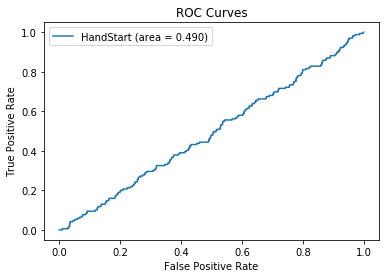

In [29]:
prediction_total = []
test_data_total = []

# models = []
# for i in range(N_LABELS):
#     models.append(init_cnn(WINDOW_SIZE))

for subject in TRAIN_SUBJECTS:
    prediction_total = []
    test_data_total = []
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]
    x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.33, shuffle=False)

    
    for i in range(1):
        model = init_cnn(WINDOW_SIZE)
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))        
        model.fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=EPOCHS)
    
    
#     for task_name, model in zip(COLUMNS, models):
#         model.save('general_model_'+task_name+'_subject_%d.h5' % (subject))  # creates a HDF5 file 'my_model.h5'
        predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)

In [ ]:
prediction_total = []
test_data_total = []

# models = []
# for i in range(N_LABELS):
#     models.append(init_cnn(WINDOW_SIZE))

for subject in range(9,10):
    prediction_total = []
    test_data_total = []
    test_features_raw = []
    train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
    x_raw, y_raw = read_training_data(train_data_paths)
    
    x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)
#     y_train = y_raw[::SUBSAMPLE]
    x_train, x_test, y_train, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.33, shuffle=True)

    
    for i in range(1):
        model = init_cnn(WINDOW_SIZE)
        
        balanced_x_train, balanced_y_train = remove_imbalance(x_train, y_train[:,i])
        
        train_labels = to_categorical(balanced_y_train, num_classes = None)
                
        print('Train subject %d, class %s' % (subject, COLUMNS[i]))        
        model.fit(balanced_x_train, train_labels, verbose=1, validation_split=0.2, epochs=EPOCHS)
    
    
#     for task_name, model in zip(COLUMNS, models):
#         model.save('general_model_'+task_name+'_subject_%d.h5' % (subject))  # creates a HDF5 file 'my_model.h5'
        predictions = predict_on_sub(x_test, model, SPLIT_SIZE, BATCH_SIZE)
        
        test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
        prediction_total.append(predictions)
        
    multiple_metric_auc_score(prediction_total, test_data_total, True)

Train subject 9, class HandStart
Train on 4123 samples, validate on 1031 samples
Epoch 1/10
4123/4123 [==============================] - 9s 2ms/step - loss: 0.6918 - acc: 0.5238 - val_loss: 0.6862 - val_acc: 0.5519
Epoch 2/10
4123/4123 [==============================] - 7s 2ms/step - loss: 0.6904 - acc: 0.5307 - val_loss: 0.6835 - val_acc: 0.5732
Epoch 3/10
4123/4123 [==============================] - 6s 2ms/step - loss: 0.6885 - acc: 0.5452 - val_loss: 0.6812 - val_acc: 0.6130
Epoch 4/10
4123/4123 [==============================] - 6s 2ms/step - loss: 0.6841 - acc: 0.5753 - val_loss: 0.6771 - val_acc: 0.6188
Epoch 5/10
4123/4123 [==============================] - 6s 2ms/step - loss: 0.6821 - acc: 0.5826 - val_loss: 0.6723 - val_acc: 0.6295
Epoch 6/10
4123/4123 [==============================] - 7s 2ms/step - loss: 0.6775 - acc: 0.5981 - val_loss: 0.6678 - val_acc: 0.6460
Epoch 7/10
 992/4123 [======>.......................] - ETA: 4s - loss: 0.6724 - acc: 0.6089

In [ ]:
# from keras.models import load_model
# for task_name, model in zip(COLUMNS, models):
#     model.save('general_model_'+task_name+'.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
# model = load_model('general_model_handstart.h5')

In [ ]:


# for subject in TEST_SUBJECTS:
#     prediction_total = []
#     test_data_total = []
#     test_features_raw = []
#     train_data_paths = glob(TRAIN_DATA_PATH % (subject))

    
#     x_raw, y_raw = read_training_data(train_data_paths)
    
#     x_raw, _ = preprocess_data(x_raw, WINDOW_SIZE, SUBSAMPLE)

#     _, x_test, _, y_test = train_test_split(x_raw, y_raw[::SUBSAMPLE], test_size=0.5)

    
#     for i in range(N_LABELS):

#         test_labels = to_categorical(y_test[:,i], num_classes = None)
                
#         print('Test subject %d, class %s' % (subject, COLUMNS[i]))                
#         predictions = predict_on_sub(x_test, models[i], SPLIT_SIZE, BATCH_SIZE)
        
#         test_data_total.append(y_test[:,i][1000::BATCH_SIZE])
#         prediction_total.append(predictions)
        
#     multiple_metric_auc_score(prediction_total, test_data_total, True)